# SensRay Basic Usage Demo

This notebook demonstrates the core SensRay functionality:
- Loading standard Earth models (PREM, AK135, etc.)
- Creating tetrahedral meshes
- Populating seismic properties
- Basic visualization and cross-sections

In [1]:
import numpy as np
from sensray import PlanetModel, CoordinateConverter
import matplotlib.pyplot as plt

/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1. Load a Standard Earth Model

SensRay includes standard models like PREM, AK135, IASP91, etc.

In [2]:
# Load PREM model
model = PlanetModel.from_standard_model('prem')

# Show available models
print("Available models:", PlanetModel.list_standard_models()[:5], "...")
print(f"Model radius: {model.radius:.1f} km")
print(f"Discontinuities at depths: {model.get_discontinuities(as_depths=True)[:4]} km (first 4)")

Available models: ['1066a', '1066b', 'M1', 'M2', 'M3'] ...
Model radius: 6371.0 km
Discontinuities at depths: [0.0, 24.399999999999636, 2891.0, 5149.5] km (first 4)


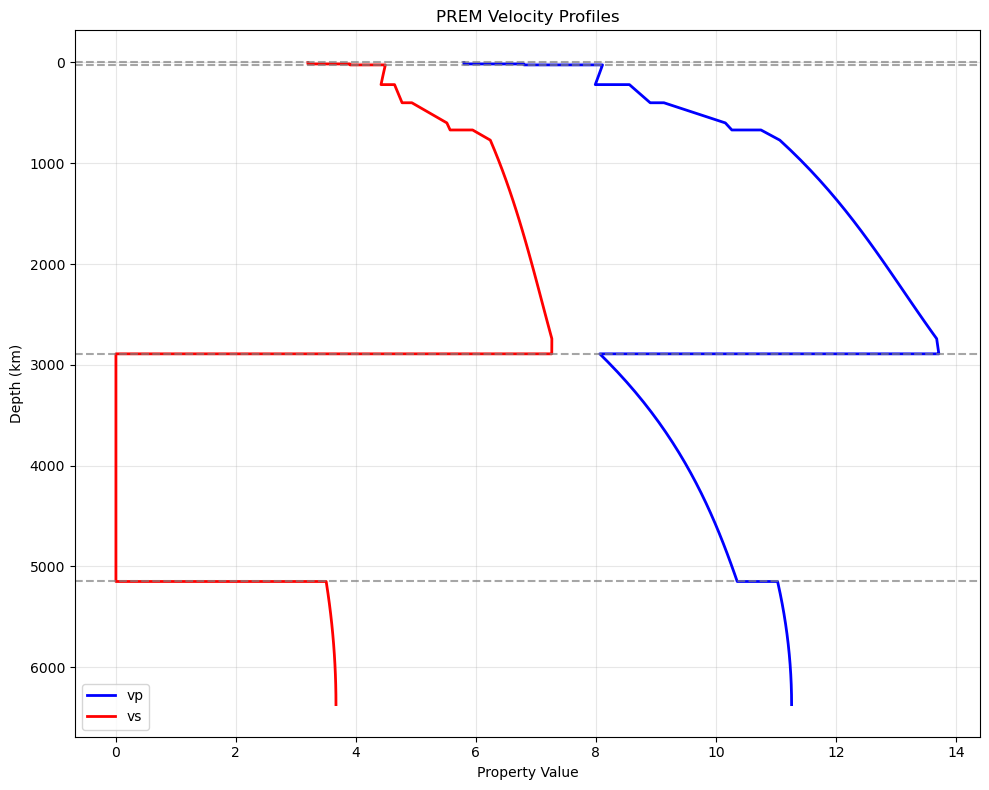

In [3]:
# Plot 1D velocity profiles
fig, ax = model.plot_profiles(properties=['vp', 'vs'], max_depth_km=6371)
plt.title('PREM Velocity Profiles')
plt.show()

                "## 2. Create Tetrahedral Meshes\n",
                "\n",
                "SensRay uses tetrahedral meshes for accurate ray tracing through complex Earth models."

In [4]:
# Create tetrahedral mesh
mesh = model.create_mesh(
    mesh_type='tetrahedral',
    mesh_size_km=500.0,
    populate_properties=['vp', 'vs', 'rho']
)
print(f"Tetrahedral mesh: {mesh.mesh.n_cells} cells, {mesh.mesh.n_points} points")

Info    : Meshing 1D...                                                                                                                       
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.00207656s, CPU 0.000621s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Sphere, Frontal-Delaunay)


Info    : Done meshing 2D (Wall 0.156664s, CPU 0.154221s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 2469 nodes...
Info    : Done tetrahedrizing 2477 nodes (Wall 0.0254636s, CPU 0.008951s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0639291s, CPU 0.04812s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 13.8695 (nodes removed 0 0)
Info    : It. 500 - 500 nodes created - worst tet radius 2.03633 (nodes removed 0 0)
Info    : It. 1000 - 1000 nodes created - worst tet radius 1.658 (nodes removed 0 0)
Info    : It. 1500 - 1500 nodes created - worst tet radius 1.46612 (nodes removed 0 0)
Info    : It. 2000 - 2000 nodes created - worst tet radius 1.34648 (nodes removed 0 0)
Info    : It. 2500 - 2499 nodes created - worst tet radius 1.25499 (nodes removed 0 1)
Inf

Info: VTU format cannot write cell_sets. Converting them to cell_data...

Generated tetrahedral mesh: 35492 cells, 7240 points
Populated properties: ['vp', 'vs', 'rho']
Tetrahedral mesh: 35492 cells, 7240 points


In [5]:
# Mesh properties are automatically populated from the 1D model
print(f"Properties populated: {list(mesh.mesh.cell_data.keys())[-3:]}")

Properties populated: ['vp', 'vs', 'rho']


## 3. Visualize Properties

Create cross-sections and spherical shells to visualize seismic properties.

In [6]:
# Cross-section through the equator (y=0 plane)
plotter = mesh.plot_cross_section(
    plane_normal=(0, 1, 0),  # y=0 plane
    property_name='vp',
    show_edges=True
)
plotter.camera.position = (10000, 8000, 8000)
plotter.show()

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7f7b65becc50_0&reconnect=auto" class="pyvi…

In [7]:
# Spherical shell at 670 km depth (upper-lower mantle boundary)
shell_radius = model.radius - 670  # 670 km depth
plotter = mesh.plot_spherical_shell(
    radius_km=shell_radius,
    property_name='vs',
    show_edges=False
)
plotter.show()

Widget(value='<iframe src="http://localhost:33103/index.html?ui=P_0x7f7b625b6ad0_1&reconnect=auto" class="pyvi…

## 4. Inspect Mesh Properties

Use built-in tools to examine what's stored on the mesh.

In [8]:
# List all properties with statistics
info = mesh.list_properties(show_stats=True)

# Show property ranges
vp_values = mesh.mesh.cell_data['vp']
print(f"\nVp range: {vp_values.min():.2f} - {vp_values.max():.2f} km/s")
print(f"Mean Vp: {vp_values.mean():.2f} km/s")

Mesh properties summary:
  cell_data keys: ['gmsh:physical', 'gmsh:geometrical', 'layer_0-gmsh:bounding_entities', 'region', 'vp', 'vs', 'rho']

Cell property summaries (first entries):
 - gmsh:physical: min=1.0, max=1.0, non_zero=35492
 - gmsh:geometrical: min=1.0, max=1.0, non_zero=35492
 - layer_0-gmsh:bounding_entities: min=0.0, max=1.0, non_zero=1
 - region: min=1.0, max=1.0, non_zero=35492
 - vp: min=7.9486260414123535, max=13.66851806640625, non_zero=35492
 - vs: min=0.0, max=7.257502555847168, non_zero=31426
 - rho: min=3.319091558456421, max=13.048653602600098, non_zero=35492

Vp range: 7.95 - 13.67 km/s
Mean Vp: 10.45 km/s


## 5. Save and Load Meshes

Meshes can be saved to VTU format with metadata for later use.

In [9]:
# Save mesh with all properties
mesh.save('prem_tet_demo')
print("Saved mesh to prem_tet_demo.vtu and prem_tet_demo_metadata.json")

# Load mesh back
loaded_mesh = model.create_mesh(from_file='prem_tet_demo')
print(f"Loaded mesh: {loaded_mesh.mesh.n_cells} cells")
print(f"Available properties: {list(loaded_mesh.mesh.cell_data.keys())}")

Saved mesh to prem_tet_demo.vtu
Saved metadata to prem_tet_demo_metadata.json
Saved mesh to prem_tet_demo.vtu and prem_tet_demo_metadata.json
Loaded mesh from prem_tet_demo.vtu
Loaded metadata: 35492 cells, 7240 points
Loaded mesh: 35492 cells
Available properties: ['gmsh:physical', 'gmsh:geometrical', 'layer_0-gmsh:bounding_entities', 'region', 'vp', 'vs', 'rho']


## Summary

This demo showed:
- Loading standard Earth models
- Creating tetrahedral meshes
- Populating seismic properties from 1D models
- Visualizing cross-sections and spherical shells
- Saving/loading meshes for reuse

Next: See `02_ray_tracing_kernels.ipynb` for ray tracing and sensitivity kernel computation.